<a href="https://colab.research.google.com/github/santossousa/TRANSFER-NCIA-DE-CONHECIMENTO-PARA-DETEC-O-AUTOM-TICA-DE-FAKE-NEWS-COM-APRENDIZAGEM-PROFUNDA/blob/main/RNN_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
#from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import itertools

from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [97]:
df = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv',delimiter=',',encoding='latin-1')
df.head()


,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

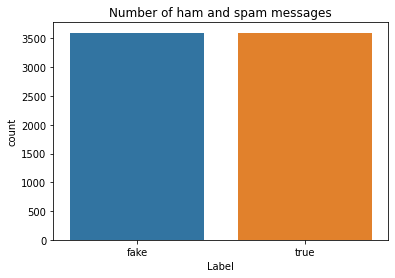

In [98]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')


In [99]:
#df = df.sample(n=1000)

In [100]:
df = df.sample(frac=1)

In [101]:
df.head()

,index,label,preprocessed_news
2465,2465,fake,globo tenta entrevistar foliao toma catracada ...
3480,3480,fake,seis policiais baleados eua noite ontem caso c...
6571,6571,true,chance unica pessoa acertar tres vezes mega vi...
6782,6782,true,penitenciaria refinaria inacabadas estao obras...
409,409,fake,eua lancam maior bomba nao nuclear mundo redut...


In [102]:
X = df.preprocessed_news
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [103]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [104]:
max_words = 10000
max_len = 500
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)



In [105]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [106]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,32,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [107]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 500)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 500, 32)           320000    
                                                                 
 lstm_7 (LSTM)               (None, 64)                24832     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [108]:
#model.fit(sequences_matrix,Y_train,batch_size=128,epochs=7,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])


In [109]:
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []

In [110]:
%time
best_model_lstm = None
best_acc = 0
for k, (train, val) in enumerate(kfold.split(sequences_matrix, Y_train)):
  print("Fold %d"%(k+1))
  history = model.fit(sequences_matrix[train],Y_train[train],batch_size=32,epochs=7,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

  scores = model.evaluate(sequences_matrix[val], Y_train[val], verbose=0)
  print(f'Score for fold {k+1}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}%')
  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  if scores[1] > best_acc:
    best_model_lstm = model
    best_acc = scores[1]


  

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Fold 1
Epoch 1/7
116/116 [==============================] - 37s 301ms/step - loss: 0.5677 - accuracy: 0.6793 - val_loss: 0.3985 - val_accuracy: 0.8243
Epoch 2/7
116/116 [==============================] - 35s 298ms/step - loss: 0.1327 - accuracy: 0.9566 - val_loss: 0.2199 - val_accuracy: 0.9306
Score for fold 1: loss of 0.17266713082790375; accuracy of 0.9427083134651184%
Fold 2
Epoch 1/7
116/116 [==============================] - 35s 299ms/step - loss: 0.1056 - accuracy: 0.9655 - val_loss: 0.2022 - val_accuracy: 0.9328
Epoch 2/7
116/116 [==============================] - 35s 298ms/step - loss: 0.0203 - accuracy: 0.9951 - val_loss: 0.4032 - val_accuracy: 0.8926
Score for fold 2: loss of 0.12473467737436295; accuracy of 0.9661458134651184%
Fold 3
Epoch 1/7
116/116 [==============================] - 35s 298ms/step - loss: 0.0171 - accuracy: 0.9954 - val_loss: 0.2505 - val_accuracy: 0.9338
Epoch 2/7
116/116 [==================

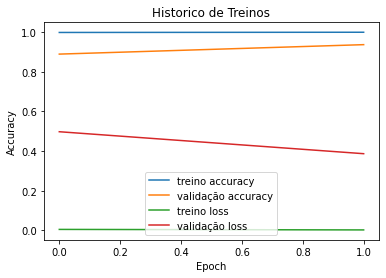

In [111]:
plt.plot(history.history['accuracy'], label='treino accuracy')
plt.plot(history.history['val_accuracy'], label='validação accuracy')
plt.plot(history.history['loss'], label='treino loss')
plt.plot(history.history['val_loss'], label='validação loss')   
plt.title('Historico de Treinos')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

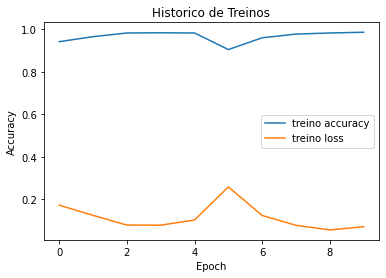

In [133]:
plt.plot(acc_per_fold, label='treino accuracy')
plt.plot(loss_per_fold, label='treino loss')
plt.title('Historico de Treinos')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [113]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


In [114]:
accr = best_model_lstm.evaluate(test_sequences_matrix,Y_test)

45/45 [==============================] - 3s 62ms/step - loss: 0.3663 - accuracy: 0.9410


In [115]:
prediction_ = best_model_lstm.predict(test_sequences_matrix)

In [116]:
matrix = confusion_matrix(Y_test.argmax(axis=1), prediction_.argmax(axis=1))
cnf_matrix_test = confusion_matrix(Y_test, prediction_.round())


Confusion matrix, without normalization
[[653  57]
 [ 28 702]]


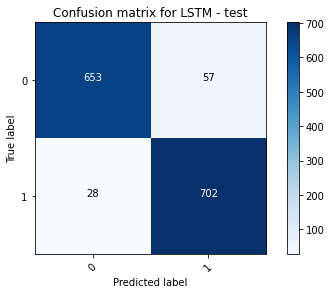

In [117]:
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for LSTM - test')

In [118]:
print(classification_report(Y_test, prediction_.round()))


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       710
           1       0.92      0.96      0.94       730

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



In [119]:
n_unique_words = 10000 # cut texts after this number of words
maxlen = 500
batch_size = 128

In [120]:
def BI_LSTM():
  model_ = Sequential()
  model_.add(Embedding(n_unique_words, 128, input_length=maxlen))
  model_.add(Bidirectional(LSTM(64)))
  model_.add(Dropout(0.5))
  model_.add(Dense(1, activation='sigmoid'))
  model_.summary()
  return model_
model_ = BI_LSTM()
model_.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [121]:
%time
best_model_lstm_bi = None
best_acc = 0
for k, (train, val) in enumerate(kfold.split(sequences_matrix, Y_train)):
  print("Fold %d"%(k+1))
  history = model_.fit(sequences_matrix[train],Y_train[train],batch_size=32,epochs=7,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

  scores = model_.evaluate(sequences_matrix[val], Y_train[val], verbose=0)
  print(f'Score for fold {k+1}: {model_.metrics_names[0]} of {scores[0]}; {model_.metrics_names[1]} of {scores[1]}%')
  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  if scores[1] > best_acc:
    best_model_lstm_bi = model_
    best_acc = scores[1]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs
Fold 1
Epoch 1/7
116/116 [==============================] - 86s 712ms/step - loss: 0.5603 - accuracy: 0.7610 - val_loss: 0.3578 - val_accuracy: 0.8742
Epoch 2/7
116/116 [==============================] - 78s 675ms/step - loss: 0.2181 - accuracy: 0.9316 - val_loss: 0.2412 - val_accuracy: 0.9165
Score for fold 1: loss of 0.2588765025138855; accuracy of 0.9053819179534912%
Fold 2
Epoch 1/7
116/116 [==============================] - 78s 675ms/step - loss: 0.1494 - accuracy: 0.9547 - val_loss: 0.2812 - val_accuracy: 0.8991
Epoch 2/7
116/116 [==============================] - 78s 671ms/step - loss: 0.0899 - accuracy: 0.9745 - val_loss: 0.1979 - val_accuracy: 0.9371
Score for fold 2: loss of 0.12426339089870453; accuracy of 0.9609375%
Fold 3
Epoch 1/7
116/116 [==============================] - 78s 672ms/step - loss: 0.0767 - accuracy: 0.9805 - val_loss: 0.2569 - val_accuracy: 0.9349
Epoch 2/7
116/116 [============================

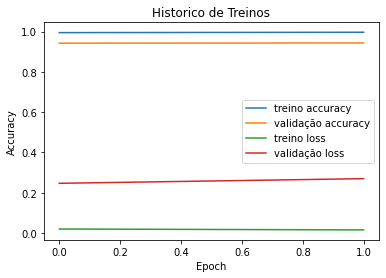

In [122]:
plt.plot(history.history['accuracy'], label='treino accuracy')
plt.plot(history.history['val_accuracy'], label='validação accuracy')  
plt.plot(history.history['loss'], label='treino loss')
plt.plot(history.history['val_loss'], label='validação loss')
plt.title('Historico de Treinos')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [123]:
#history=model_.fit(sequences_matrix,Y_train,batch_size=128,epochs=7,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

In [124]:
prediction = best_model_lstm_bi.predict(test_sequences_matrix)

In [125]:
accr = best_model_lstm_bi.evaluate(test_sequences_matrix,Y_test)

45/45 [==============================] - 6s 129ms/step - loss: 0.2748 - accuracy: 0.9410


In [126]:
matrix = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1))

In [127]:
cnf_matrix_test = confusion_matrix(Y_test, prediction.round())
print(cnf_matrix_test)

[[660  50]
 [ 35 695]]


In [128]:
import itertools

Confusion matrix, without normalization
[[660  50]
 [ 35 695]]


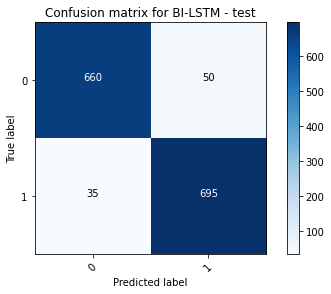

In [129]:
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for BI-LSTM - test')

In [130]:
print(classification_report(Y_test, prediction.round()))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       710
           1       0.93      0.95      0.94       730

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



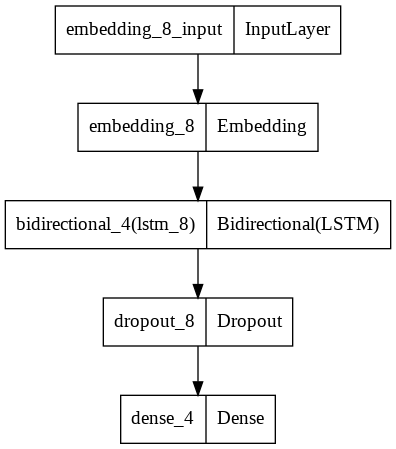

In [131]:
from keras.utils.vis_utils import plot_model
plot_model(model_, to_file='model.png')

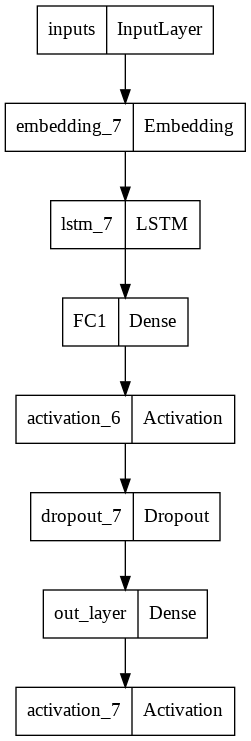

In [132]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')